### E. Clothing Classification
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples
and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from
10 classes. One can design a convolutional neural network or Transformer to address the classification
problem. 

#### Some tasks to consider:
1. Modify some previously published architectures e.g., increase the network depth, reducing their
parameters, etc. Explore more dilated techniques such as deformable convolution, dilated
convolution (dilation>1) or visual prompt tuning for Transformers.
2. Use more dilated transformation techniques such as MixUp (see the original paper and its
PyTorch implementation here)
3. Comparing the performance of different network architectures

#### References:
- [Deep Learning CNN for Fashion-MNIST Clothing Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/)

#### Datasets:
- [Dataset available in TorchVision](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)

<br><br> 

# 1. CNN

In [ ]:
! pip install torch torchvision matplotlib scikit-learn seaborn

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [13]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 15

In [14]:
# Define transformations for the dataset
transform = transforms.Compose([
   transforms.ToTensor(),  # Convert PIL images to tensors
   transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

In [15]:
# Load the training dataset
train_dataset = datasets.FashionMNIST(
   root='./data',  # Directory to store the dataset
   train=True,  # Load training data
   transform=transform,  # Apply transformations
   download=True  # Download the dataset if not already present
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
   root='./data',
   train=False,  # Load test data
   transform=transform,
   download=True
)

# print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [16]:
# Create DataLoaders for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

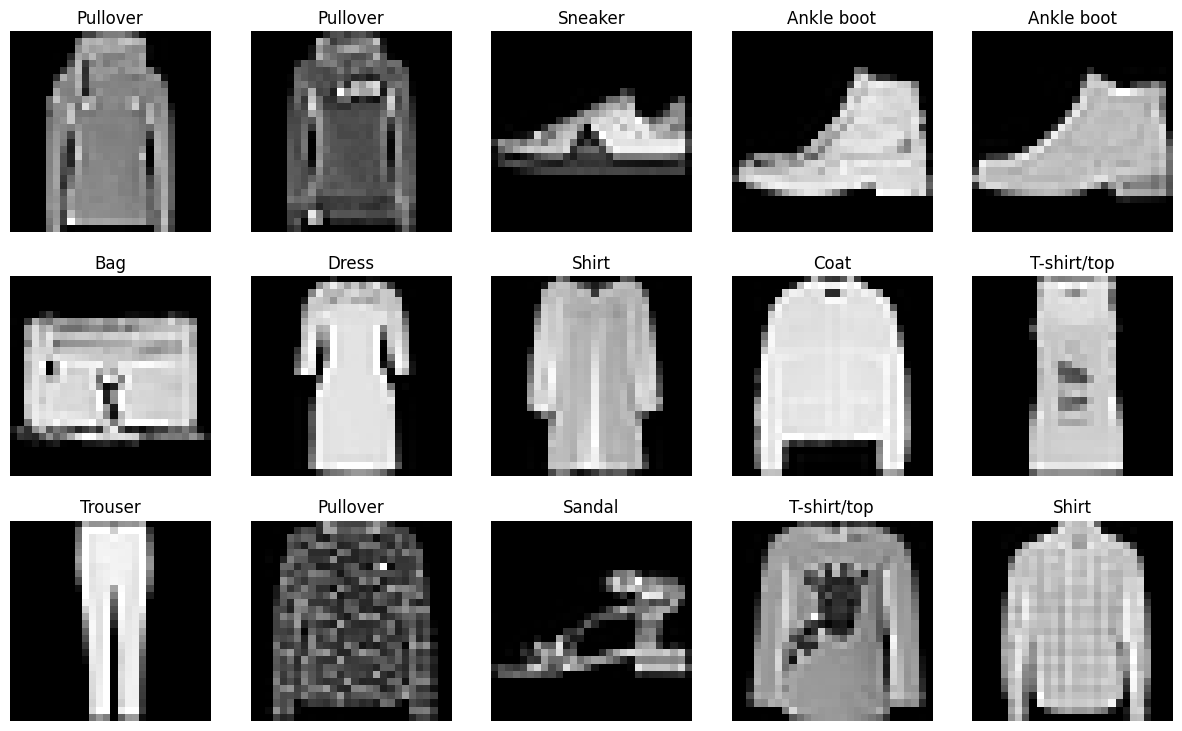

In [17]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to show images
def show_images(images, labels, grid_size=(3, 5), figsize=(15, 9), title=None):
	plt.figure(figsize=figsize)
	images = images.cpu()  # Move to CPU if they're on GPU
	for i in range(grid_size[0] * grid_size[1]):
		
		plt.subplot(grid_size[0], grid_size[1], i + 1)
		plt.imshow(images[i].squeeze(), cmap='gray')
		plt.title(classes[labels[i]])
		plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a batch of images
show_images(images[:15], labels[:15], title="Sample Fashion-MNIST Images")

Models

In [18]:
class StandardCNN(nn.Module):
   def __init__(self):
      super(StandardCNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                   # 28x28 -> 14x14
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 14x14 -> 14x14
      self.fc1 = nn.Linear(64 * 7 * 7, 128)                              # Flattened after pool
      self.fc2 = nn.Linear(128, 10)
      
   def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))
      x = x.view(-1, 64 * 7 * 7)
      x = nn.functional.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [19]:
class DilatedCNN(nn.Module):
   def __init__(self):
      super(DilatedCNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Standard
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2, dilation=2)  # Dilated (d=2)
      self.fc1 = nn.Linear(64 * 7 * 7, 128)
      self.fc2 = nn.Linear(128, 10)
      
   def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))  # Dilated conv
      x = x.view(-1, 64 * 7 * 7)
      x = nn.functional.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [20]:
from torchvision.ops import deform_conv2d
import torch.nn.functional as F

class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DeformableConv2d, self).__init__()
        
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size
        
        # Regular convolution for learning offsets
        self.offset_conv = nn.Conv2d(in_channels, 2*kernel_size*kernel_size, 
                                    kernel_size=kernel_size, stride=stride, 
                                    padding=padding)
        
        # Initialize weights for offset conv to zero
        nn.init.constant_(self.offset_conv.weight, 0)
        nn.init.constant_(self.offset_conv.bias, 0)
        
        # Main convolution
        self.conv = nn.Conv2d(in_channels, out_channels, 
                             kernel_size=kernel_size, stride=stride, 
                             padding=padding)
        
    def forward(self, x):
        # Generate offsets
        offsets = self.offset_conv(x)
        
        # Apply deformable convolution
        x = deform_conv2d(x, offsets, self.conv.weight, self.conv.bias, 
                         stride=self.stride, padding=self.padding)
        return x

In [21]:
class DeformableCNN(nn.Module):
    def __init__(self):
        super(DeformableCNN, self).__init__()
        
        # First block - deformable convolution
        self.conv1 = DeformableConv2d(1, 32)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second block - deformable convolution
        self.conv2 = DeformableConv2d(32, 64)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third block - regular convolution
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        
        # Classifier
        self.fc1 = nn.Linear(128*3*3, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128*3*3)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Evaluate Models

In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

standard_model = StandardCNN().to(device)
dilated_model = DilatedCNN().to(device)
deformable_model = DeformableCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_standard = torch.optim.Adam(standard_model.parameters(), lr=LEARNING_RATE)
optimizer_dilated = torch.optim.Adam(dilated_model.parameters(), lr=LEARNING_RATE)
optimizer_deformable = torch.optim.Adam(deformable_model.parameters(), lr=LEARNING_RATE)

In [24]:

def train_and_validate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, model_name):
   model.train()
   train_losses = []
   train_accs = []
   val_losses = []
   val_accs = []
   
   for epoch in range(num_epochs):
      # Training phase
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0
      
      for images, labels in train_loader:
         images, labels = images.to(device), labels.to(device)
         
         optimizer.zero_grad()
         outputs = model(images)
         loss = criterion(outputs, labels)
         loss.backward()
         optimizer.step()
         
         running_loss += loss.item()
         _, predicted = torch.max(outputs.data, 1)
         total += labels.size(0)
         correct += (predicted == labels).sum().item()
      
      train_loss = running_loss / len(train_loader)
      train_acc = 100 * correct / total
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      
      # Validation phase
      model.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      
      with torch.no_grad():
         for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
      
      val_loss = val_loss / len(test_loader)
      val_acc = 100 * correct / total
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      
      print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
   
   return train_losses, train_accs, val_losses, val_accs

# Train both models and collect metrics
standard_train_loss, standard_train_acc, standard_val_loss, standard_val_acc = train_and_validate_model(
   standard_model, train_loader, test_loader, criterion, optimizer_standard, NUM_EPOCHS, "Standard CNN")

dilated_train_loss, dilated_train_acc, dilated_val_loss, dilated_val_acc = train_and_validate_model(
   dilated_model, train_loader, test_loader, criterion, optimizer_dilated, NUM_EPOCHS, "Dilated CNN")

deformable_train_loss, deformable_train_acc, deformable_val_loss, deformable_val_acc = train_and_validate_model(
	deformable_model, train_loader, test_loader, criterion, optimizer_deformable, NUM_EPOCHS, "Deformable CNN")


Standard CNN - Epoch [1/15], Train Loss: 0.2684, Train Acc: 90.33%, Val Loss: 0.2847, Val Acc: 89.90%
Standard CNN - Epoch [2/15], Train Loss: 0.2264, Train Acc: 91.74%, Val Loss: 0.2530, Val Acc: 91.03%
Standard CNN - Epoch [3/15], Train Loss: 0.1935, Train Acc: 92.86%, Val Loss: 0.2564, Val Acc: 90.83%
Standard CNN - Epoch [4/15], Train Loss: 0.1703, Train Acc: 93.67%, Val Loss: 0.2498, Val Acc: 91.54%
Standard CNN - Epoch [5/15], Train Loss: 0.1488, Train Acc: 94.49%, Val Loss: 0.2311, Val Acc: 92.27%
Standard CNN - Epoch [6/15], Train Loss: 0.1279, Train Acc: 95.28%, Val Loss: 0.2521, Val Acc: 91.73%
Standard CNN - Epoch [7/15], Train Loss: 0.1081, Train Acc: 96.00%, Val Loss: 0.2652, Val Acc: 91.58%
Standard CNN - Epoch [8/15], Train Loss: 0.0922, Train Acc: 96.57%, Val Loss: 0.2828, Val Acc: 91.78%
Standard CNN - Epoch [9/15], Train Loss: 0.0771, Train Acc: 97.17%, Val Loss: 0.2905, Val Acc: 91.70%
Standard CNN - Epoch [10/15], Train Loss: 0.0637, Train Acc: 97.65%, Val Loss: 0.3

Plot Model Results

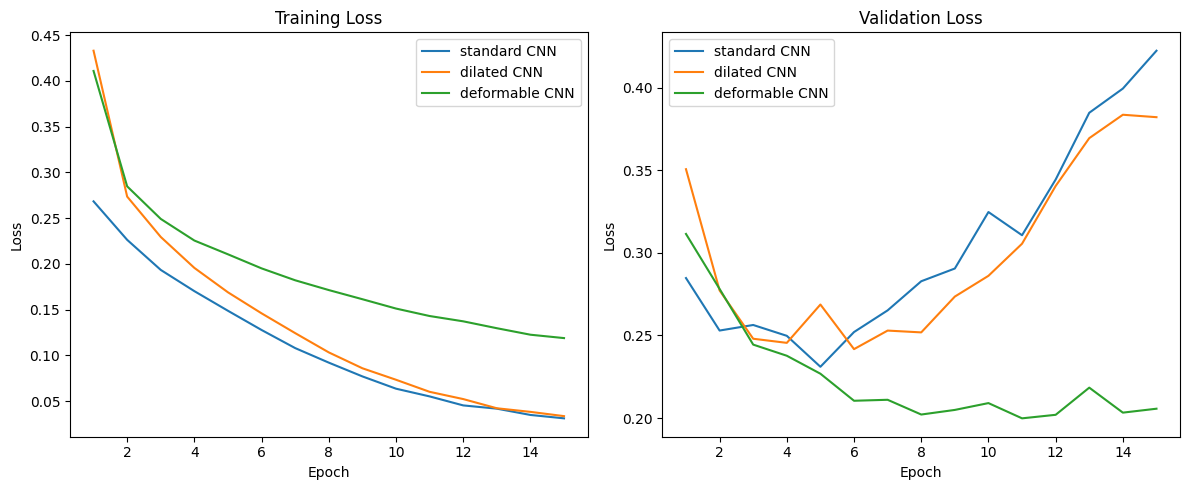

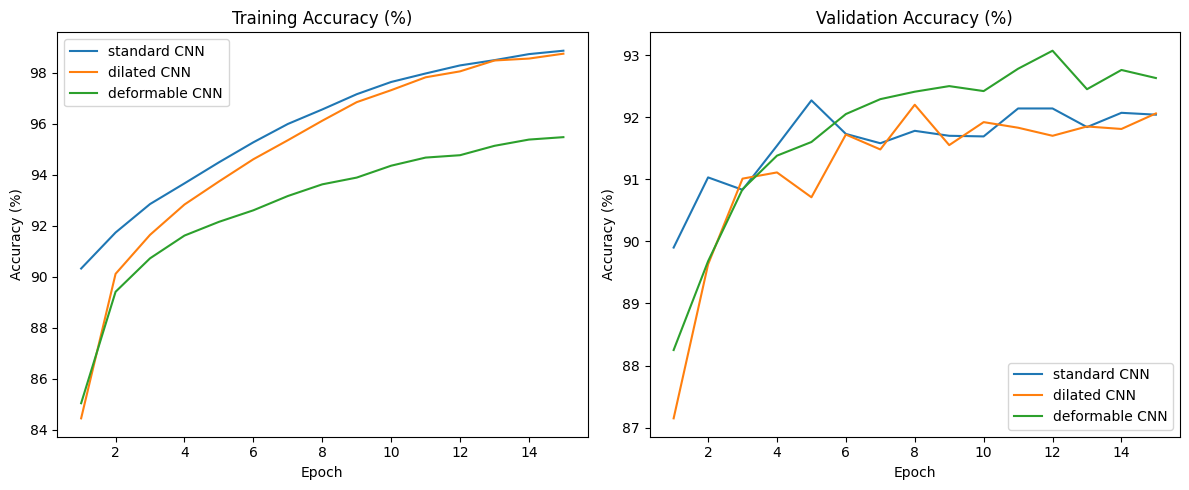

In [30]:

# Plotting function
def plot_metrics(epochs, standard_metrics, dilated_metrics,deformable_metrics, standard_val, dilated_val,deformable_val, metric_name):
   plt.figure(figsize=(12, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, epochs+1), standard_metrics, label='standard CNN')
   plt.plot(range(1, epochs+1), dilated_metrics, label='dilated CNN')
   plt.plot(range(1, epochs+1), deformable_metrics, label='deformable CNN')
   plt.xlabel('Epoch')
   plt.ylabel(metric_name)
   plt.title(f'Training {metric_name}')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, epochs+1), standard_val, label='standard CNN')
   plt.plot(range(1, epochs+1), dilated_val, label='dilated CNN')
   plt.plot(range(1, epochs+1), deformable_val, label='deformable CNN')
   plt.xlabel('Epoch')
   plt.ylabel(metric_name)
   plt.title(f'Validation {metric_name}')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Plot Loss curves
plot_metrics(NUM_EPOCHS, standard_train_loss, dilated_train_loss, deformable_train_loss,
            standard_val_loss, dilated_val_loss, deformable_val_loss, 'Loss')
# Plot Accuracy curves
plot_metrics(NUM_EPOCHS, standard_train_acc, dilated_train_acc,  deformable_train_acc,
            standard_val_acc, dilated_val_acc, deformable_val_acc, 'Accuracy (%)')

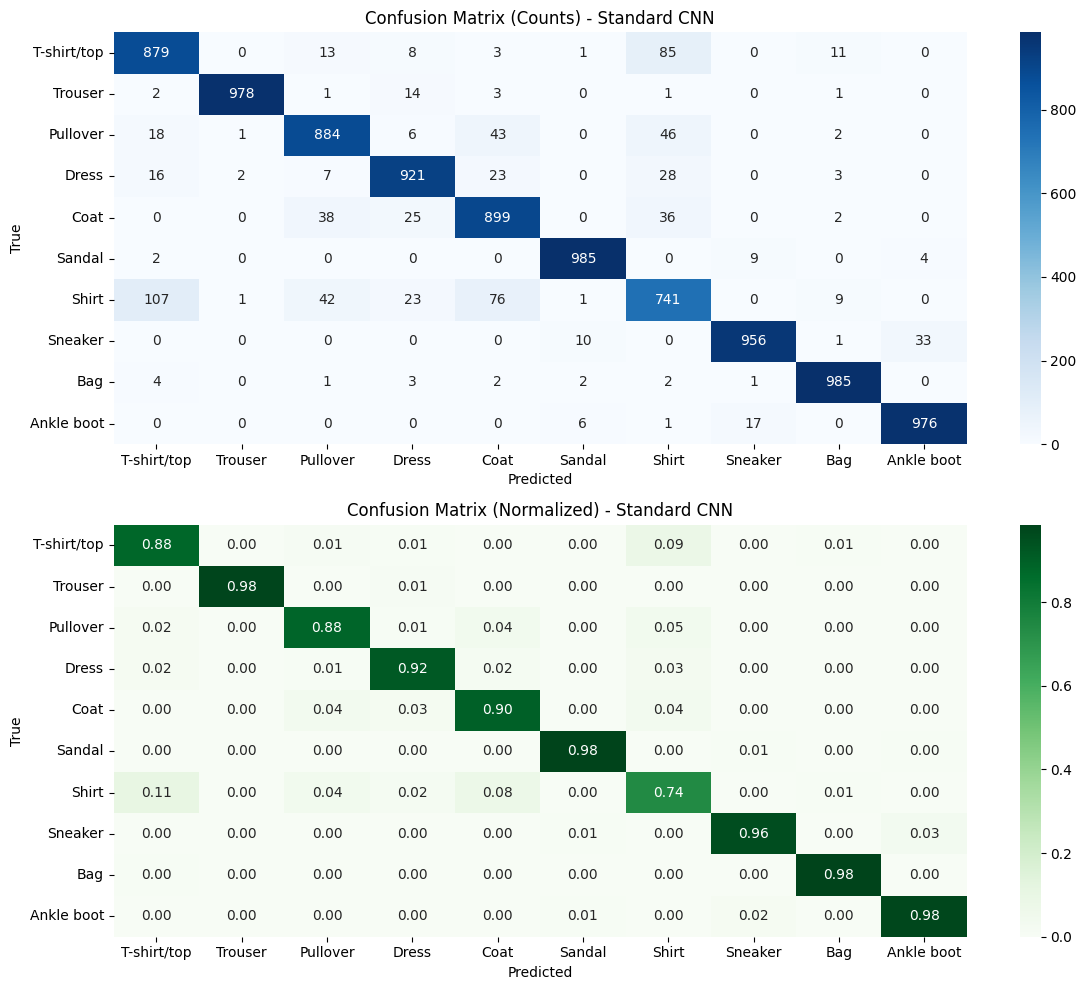

Classification Report for Standard CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.86      0.90      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.79      0.74      0.76      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



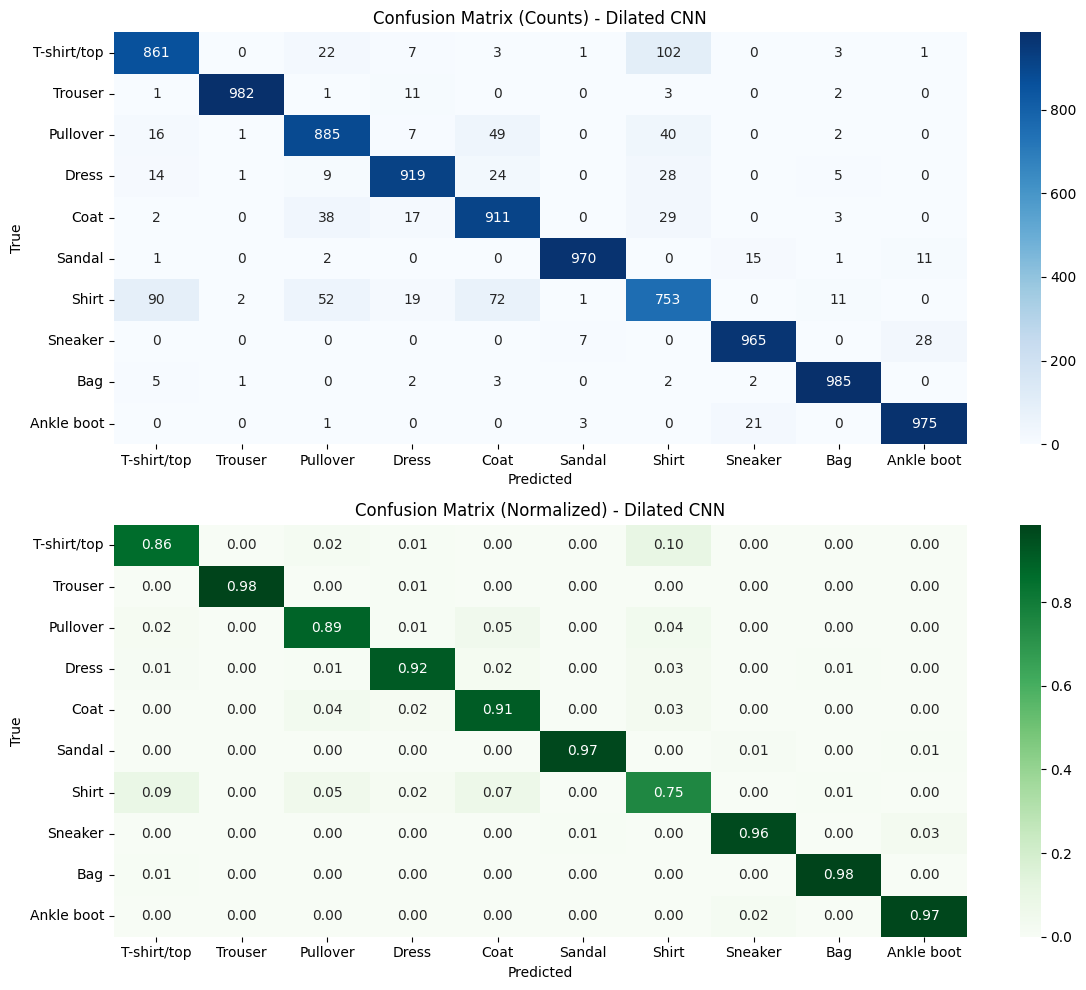

Classification Report for Dilated CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.86      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.89      0.88      1000
       Dress       0.94      0.92      0.93      1000
        Coat       0.86      0.91      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.75      0.77      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



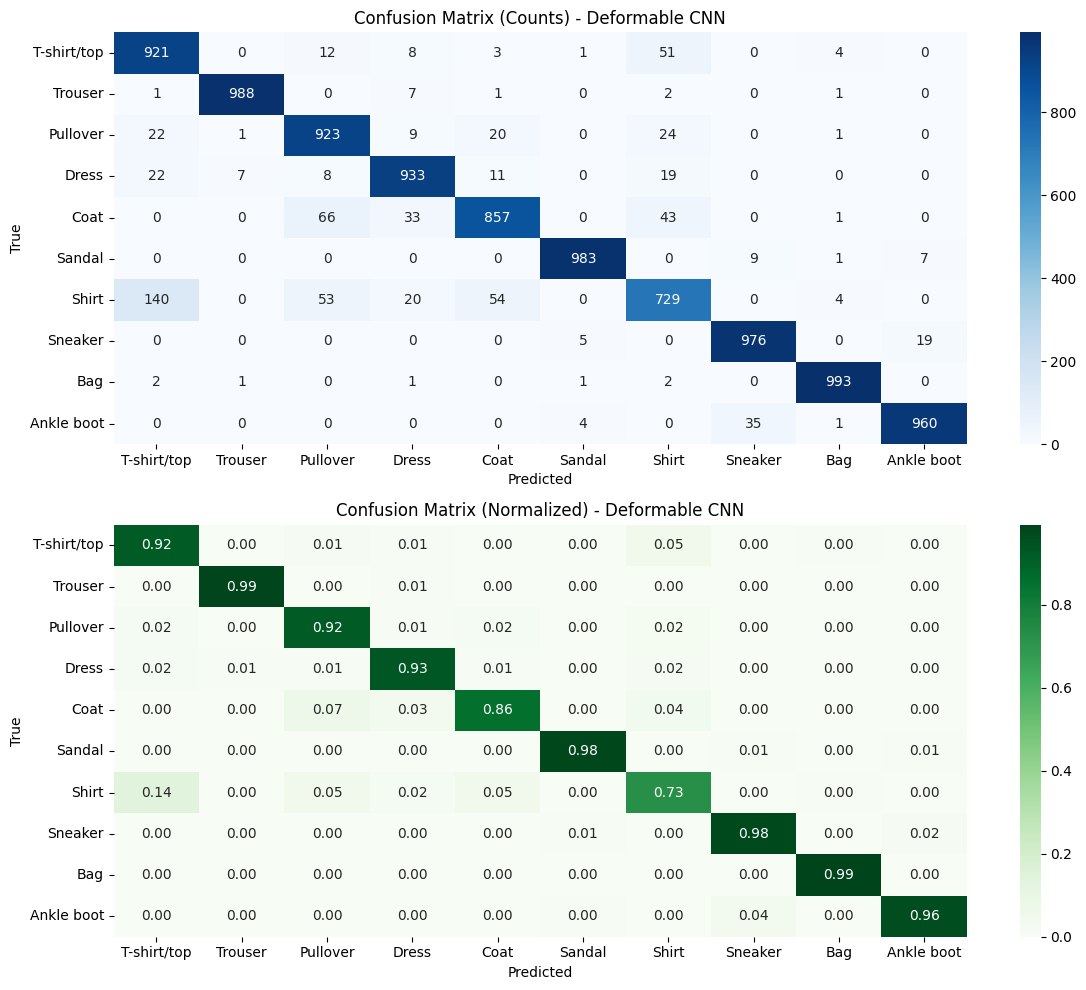

Classification Report for Deformable CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.92      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.87      0.92      0.90      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.91      0.86      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.84      0.73      0.78      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [31]:
def plot_confusion_matrix_enhanced(model, test_loader, model_name):
   model.eval()
   all_preds = []
   all_labels = []
   
   with torch.no_grad():
       for images, labels in test_loader:
           images = images.to(device)
           labels = labels.to(device)
           outputs = model(images)
           _, preds = torch.max(outputs, 1)
           all_preds.extend(preds.cpu().numpy())
           all_labels.extend(labels.cpu().numpy())
   
   # Compute confusion matrix
   cm = confusion_matrix(all_labels, all_preds)
   cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
   # Plot
   plt.figure(figsize=(12, 10))
   
   # Plot counts
   plt.subplot(2, 1, 1)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=classes, yticklabels=classes)
   plt.title(f'Confusion Matrix (Counts) - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   
   # Plot percentages
   plt.subplot(2, 1, 2)
   sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
               xticklabels=classes, yticklabels=classes)
   plt.title(f'Confusion Matrix (Normalized) - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   
   plt.tight_layout()
   plt.show()

   print(f"Classification Report for {model_name}:\n")
   print(classification_report(all_labels, all_preds, target_names=classes))
   

# Plot enhanced confusion matrices
plot_confusion_matrix_enhanced(standard_model, test_loader, "Standard CNN")
plot_confusion_matrix_enhanced(dilated_model, test_loader, "Dilated CNN")
plot_confusion_matrix_enhanced(deformable_model, test_loader, "Deformable CNN")

